## Project Eclipse data on the Planetary Computer

The [Project Eclipse Network](https://planetarycomputer.microsoft.com/dataset/eclipse) is a low-cost air quality sensing network for cities and a research project led by the Urban Innovation Group at Microsoft Research.

### Using the STAC API

Project Eclipse data are distributed as a set of parquet files -- one per week. We can use the STAC API to search for files for a specific week.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(collections=["eclipse"], datetime="2022-03-01")
items = search.get_all_items()
print(f"Found {len(items)} item")
item = items[0]
item

Found 1 item


ID: Chicago-2022-02-27
"Bounding Box: [-87.94011408, 41.64454312, -87.5241371, 42.02303859]"
datetime: None
end_datetime: 2022-03-06T00:00:00Z
"table:columns: [{'name': 'City', 'type': 'byte_array', 'description': 'City where the Microsoft Eclipse device is deployed'}, {'name': 'DeviceId', 'type': 'int32', 'description': 'Id for a given device'}, {'name': 'LocationName', 'type': 'byte_array', 'description': 'Unique string describing the device location'}, {'name': 'Latitude', 'type': 'double', 'description': 'Latitude of the device location'}, {'name': 'Longitude', 'type': 'double', 'description': 'Longitude of the device location'}, {'name': 'ReadingDateTimeUTC', 'type': 'int96', 'description': 'The UTC date time string (like 2022-03-04 20:27:25.000) when the reading from the Eclipse sensor was recorded'}, {'name': 'PM25', 'type': 'double', 'description': 'Uncalibrated Fine particulate matter (PM 2.5) in µg/m³'}, {'name': 'CalibratedPM25', 'type': 'double', 'description': 'Calibrated PM 2.5 in µg/m³'}, {'name': 'Humidity', 'type': 'double', 'description': 'Relative humidity'}, {'name': 'O3', 'type': 'double', 'description': 'Uncalibrated Ozone in ppb'}, {'name': 'NO2', 'type': 'double', 'description': 'Uncalibrated Nitrogen Dioxide in ppb'}, {'name': 'CO', 'type': 'double', 'description': 'Uncalibrated Carbon monoxide (CO) in PPM'}, {'name': 'BatteryLevel', 'type': 'double', 'description': 'Device battery level in Volts'}, {'name': 'PercentBattery', 'type': 'double', 'description': 'Percent of device battery'}, {'name': 'CellSignal', 'type': 'double', 'description': 'Cellular signal strength in dB'}]"
start_datetime: 2022-02-27T00:00:00Z
stac_extensions: ['https://stac-extensions.github.io/table/v1.2.0/schema.json']
https://stac-extensions.github.io/table/v1.2.0/schema.json
href: abfs://eclipse/Chicago/2022-02-27/20220227-00_20220306-00.parquet
Title: Weekly dataset
Media type: application/x-parquet


We'll load the parquet file with pandas.

In [2]:
import geopandas
import pandas as pd

asset = item.assets["data"]
df = pd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,CalibratedO3,CalibratedNO2,CO,Temperature,Humidity,BatteryLevel,PercentBattery,CellSignal
0,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:04:04,9.126071,10.79,17.53,10.49,0.105193,-0.526352,59.703064,4.143906,91.634804,-83.0
1,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:09:14,10.927937,11.83,15.72,8.46,0.114015,-0.649185,60.223389,4.142812,91.634804,-80.0
2,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:14:24,10.395282,11.38,18.29,5.25,0.096386,-0.627823,60.884094,4.141094,91.634804,-82.0
3,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:19:33,9.431242,10.85,15.11,8.53,0.119355,-0.809402,61.984253,4.142969,91.385475,-81.0
4,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:24:44,9.648221,11.05,12.29,9.92,0.125682,-0.809402,62.377930,4.142344,91.385475,-82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189055,Chicago,2214,EPA COM ED Maintenance Bldg F,41.751200,-87.713490,2022-03-05 22:33:08,0.747107,8.43,14.76,13.74,0.285773,19.898682,53.863525,4.184062,89.785156,-110.0
189056,Chicago,2214,EPA COM ED Maintenance Bldg F,41.751200,-87.713490,2022-03-05 22:53:22,0.733524,10.31,14.37,20.18,1.288297,20.149689,54.324341,4.187969,89.785156,-111.0
189057,Chicago,2214,EPA COM ED Maintenance Bldg F,41.751200,-87.713490,2022-03-05 23:13:37,0.000000,10.31,15.69,17.94,2.921081,20.024185,53.430176,4.188281,89.785156,-111.0
189058,Chicago,2214,EPA COM ED Maintenance Bldg F,41.751200,-87.713490,2022-03-05 23:33:57,3.208157,11.90,14.00,20.47,0.784464,20.149689,53.668213,4.183750,89.785156,-109.0


In [3]:
df = df[(df.Longitude > -89) & (df.Longitude < -86)]
len(df)

189060

In [ ]:
df.CalibratedO3

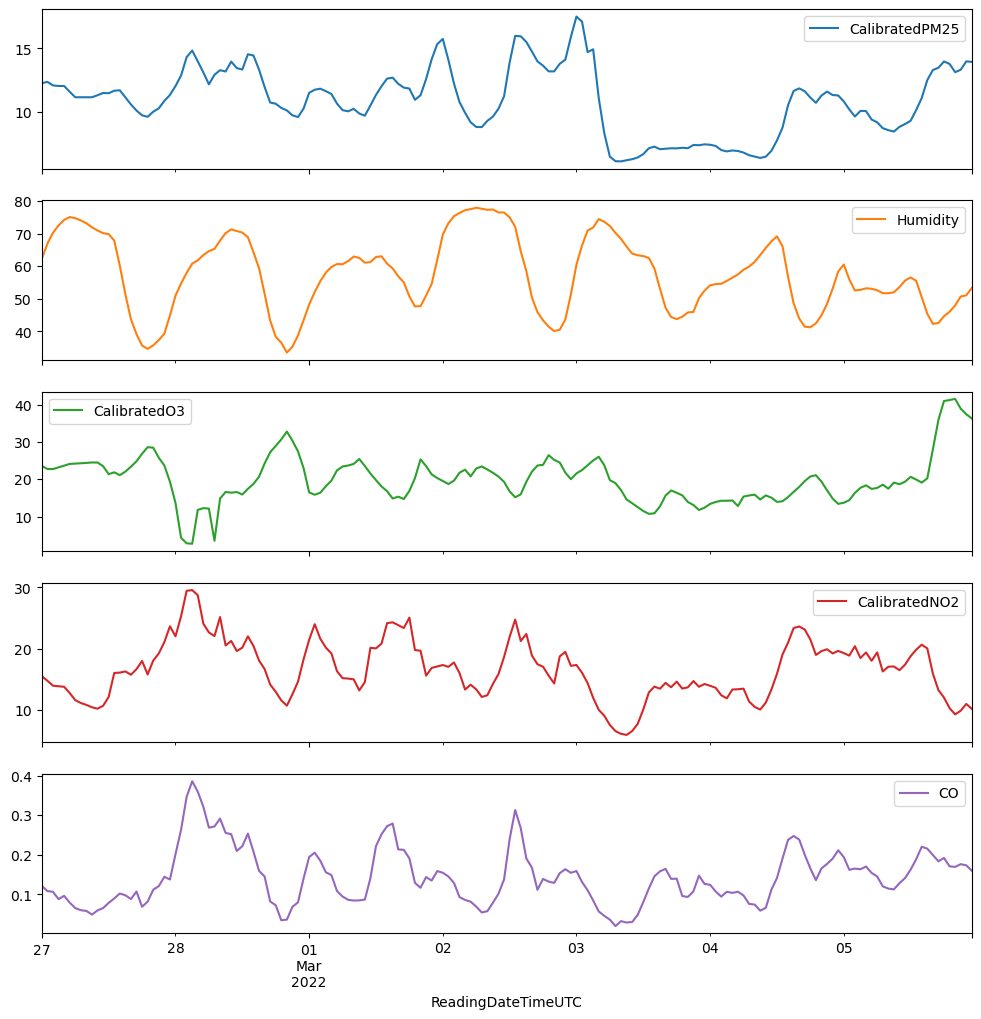

In [5]:
ts = df.resample("H", on="ReadingDateTimeUTC")[
    ["CalibratedPM25", "Humidity", "CalibratedO3", "CalibratedNO2", "CO"]
].mean()
ts.plot(subplots=True, sharex=True, figsize=(12, 12));

The dataset contains many observations from each sensor. We can plot the location of each sensor with geopandas, by selecting just the first observation for that sensor.

In [6]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="epsg:4326"
)


gdf[["LocationName", "geometry"]].drop_duplicates(
    subset="LocationName"
).dropna().explore(marker_kwds=dict(radius=8))

Using a [named aggregation](https://pandas.pydata.org/docs/user_guide/groupby.html#named-aggregation) we can compute a summary per senor and plot it on a map. Hover over the markers to see the average Calibrated PM 25 per sensor.

In [7]:
average_pm25 = geopandas.GeoDataFrame(
    gdf.groupby("LocationName").agg(
        mean_pm25=("CalibratedPM25", "mean"), geometry=("geometry", "first")
    ),
    crs="epsg:4326",
)
average_pm25.explore(
    marker_kwds=dict(radius=10),
)

### Reading the full dataset

The STAC collection includes a `data` asset, which links to the root of the parquet dataset. This can be used to read all of the data across time. We'll use [Dask](https://docs.dask.org/) to read in the dataset.

In [8]:
eclipse = catalog.get_collection("eclipse")
asset = planetary_computer.sign(eclipse.assets["data"])

In [9]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,CalibratedO3,CalibratedNO2,CO,Temperature,Humidity,BatteryLevel,PercentBattery,CellSignal
npartitions=68,,,,,,,,,,,,,,,,
,object,int32,object,float64,float64,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
